In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [70]:
def set_plot_params(title, ylabel):
    plt.title(title)
    plt.ylabel(ylabel, fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=30, fontsize=12)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))


def calculate_ylim(data):
    ylim_min = min(data) - (max(data) - min(data)) * 0.1
    ylim_max = max(data) + (max(data) - min(data)) * 0.1
    return ylim_min, ylim_max


def draw_graph(data: pd.DataFrame, title: str, ylabel: str, date_lst: list, color="blue"):
    '''
    :param data: 시간 인덱스와 그래프로 표시할 정보가 있는 데이터프레임
    :param title: 그래프 제목
    :param ylabel: 그래프 y축 단위
    :param date_lst: 아웃라이어 날짜인덱스 리스트
    :param color: 그래프 색깔
    :return: 
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data.values, color=color)
    for date in date_lst:
        plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label='Highlight Date')
    set_plot_params(title, ylabel)
    ylim_min, ylim_max = calculate_ylim(list(data.values))
    plt.ylim(ylim_min, ylim_max)
    plt.show()

In [78]:
def compute_CUSUM(X):
    N = len(X)
    CUSUM = np.zeros(N + 1)
    for k in range(1, N + 1):
        CUSUM[k] = CUSUM[k - 1] + X[k - 1] ** 2
    return CUSUM


def compute_gamma(X, T, m):
    gamma = np.zeros(m + 1)
    mean_X = np.mean(X)
    r = X - mean_X  # 잔차 계산
    r_squared = r ** 2
    sigma_squared = np.mean(r_squared)
    for i in range(1, m + 1):
        gamma_i = 0
        for t in range(i + 1, T):
            gamma_i += (r_squared[t] - sigma_squared) * (r_squared[t - i] - sigma_squared)
        gamma[i] = gamma_i / T
    return gamma


def compute_lambda(gamma, m):
    lambda_hat = gamma[0] + 2 * sum((1 - i / (m + 1)) * gamma[i] for i in range(1, m + 1))
    lambda_hat = np.abs(lambda_hat)
    return lambda_hat


def compute_D_prime(CUSUM, T, lambda_hat):
    D_prime = np.zeros(T)
    for k in range(1, T + 1):
        D_prime[k - 1] = (CUSUM[k] - (k / T) * CUSUM[T]) / np.sqrt(lambda_hat)
    return D_prime


def compute_percentile(D_prime, T, percent=95):
    D_prime_abs = np.abs(D_prime) * np.sqrt(T / 2)
    critical_value = np.percentile(D_prime_abs, percent)
    return critical_value, np.abs(D_prime)

In [72]:
name = 'perigee'
info_df = pd.read_csv('../Database/58400_new.csv', index_col=0)
info_df = info_df[info_df.index > '2022-12-31 23:59:59'].copy()
hour_df = info_df[::60].copy()
diff_value = np.log(hour_df[name].copy()).diff().fillna(0).values

start_date = hour_df.index[0]
data_length = len(hour_df)
time_index = pd.date_range(start=start_date, periods=data_length, freq='h')
hour_df.index = time_index

In [73]:
x_df = np.log(hour_df[name].copy()).diff().fillna(0)
y_df = hour_df[name]

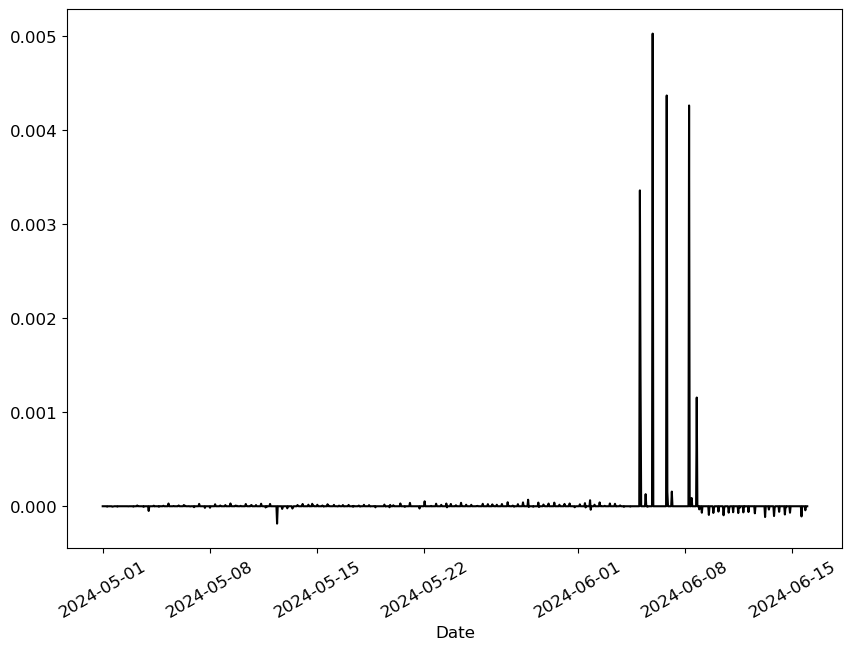

In [74]:
x_idx = x_df.loc['2024-05-01':'2024-06-15'].index
plt.figure(figsize=(10, 7), dpi=400)
plt.xlabel("Date", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=30, fontsize=12)
plt.plot(x_idx, x_df.loc['2024-05-01':'2024-06-15'], color='black')

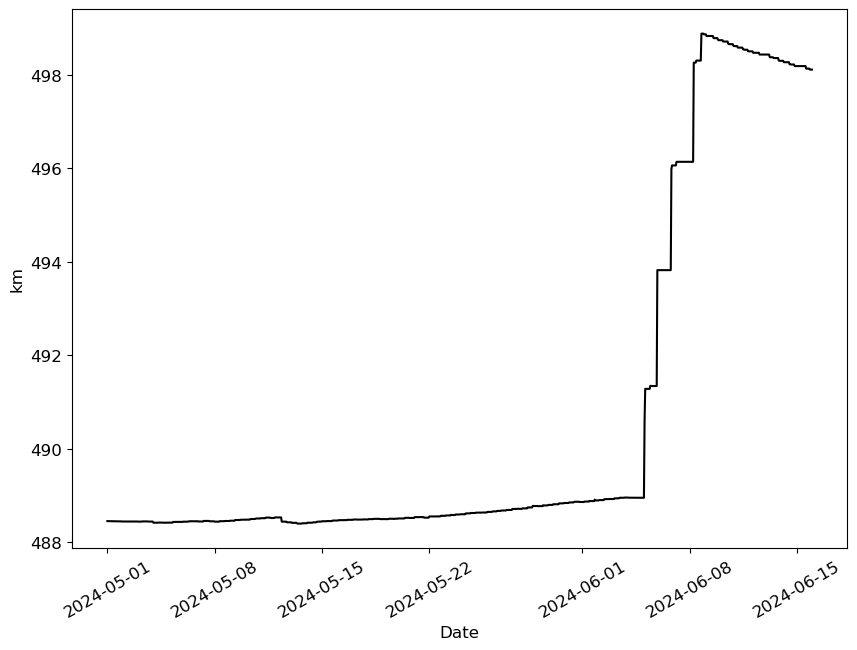

In [75]:
y_idx = y_df.loc['2024-05-01':'2024-06-15'].index
plt.figure(figsize=(10, 7), dpi=400)
plt.ylabel("km", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=30, fontsize=12)
plt.plot(y_idx, y_df.loc['2024-05-01':'2024-06-15'], color='black')

In [79]:
lambda_lst = []
cv_lst = []
current_lst = []
ol_lst = []
D_k_abs_lst = []

window_size = 24 * 7 * 4
for i in tqdm(range(window_size, len(diff_value) + 1, 1)):
    count = 0
    filter = []
    for val in ol_lst:
        if (i - window_size <= val) and (val < i):
            count += 1
            filter.append(val - (i))

    X = diff_value[i - window_size - count: i].copy()

    if len(filter) != 0:
        X = np.delete(X, filter)

    N = len(X)
    T = N
    m = int(T ** (1 / 4))

    # CUSUM 계산
    CUSUM = compute_CUSUM(X)
    # gamma 계산
    gamma = compute_gamma(X, T, m)
    # lambda_hat 계산
    lambda_hat = compute_lambda(gamma, m)
    lambda_lst.append(lambda_hat)
    # D_prime 계산
    D_prime = compute_D_prime(CUSUM, T, lambda_hat)
    # critical value 계산
    critical_value, D_k_abs = compute_percentile(D_prime, T, 99)
    cv_lst.append(critical_value)
    D_k_abs_lst.append(D_k_abs)
    # 현재 통계량 계산
    current_lst.append(np.abs(D_prime[-2]) * np.sqrt(T / 2))

    if current_lst[-1] > critical_value:
        ol_lst.append(i - 1)

ol_lst = list(np.where((np.array(current_lst) > np.array(cv_lst)))[0] + window_size)
print(len(ol_lst))

100%|██████████| 5722/5722 [00:18<00:00, 307.71it/s]

12


In [83]:
D_k_df=pd.DataFrame(data=D_k_abs_lst, index=pd.date_range(start=start_date, periods=5722, freq='h'))

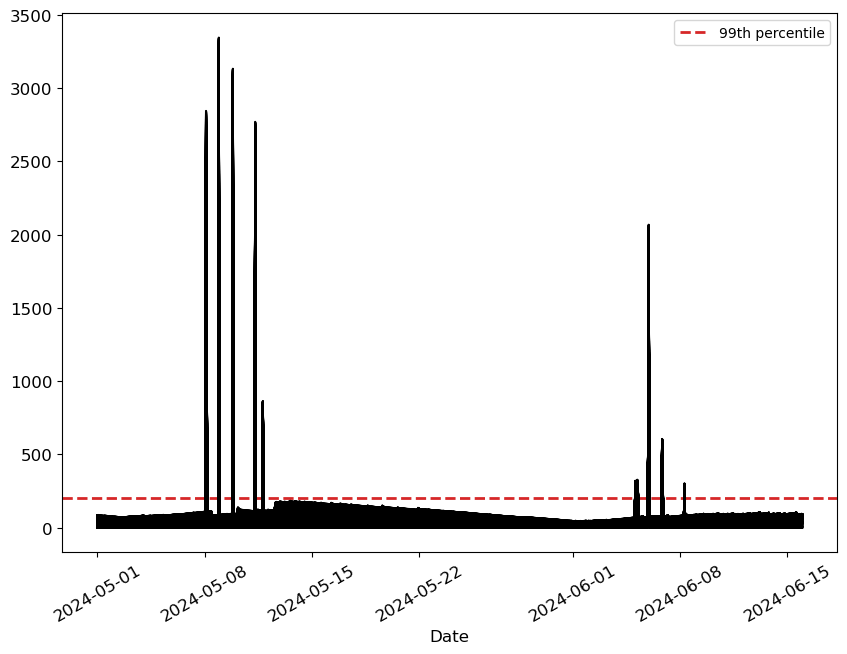

In [92]:
D_idx = D_k_df.loc['2024-05-01':'2024-06-15'].index
plt.figure(figsize=(10, 7), dpi=400)
plt.xlabel("Date", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=30, fontsize=12)
plt.axhline(200, color='tab:red', linewidth=2, linestyle='--', label='99th percentile')
plt.plot(D_idx, D_k_df.loc['2024-05-01':'2024-06-15'], color='black')
plt.legend()

In [100]:
len(hour_df[name])

6393

In [101]:
len(hour_df[name].loc['2024-05-01':'2024-06-15'])

1104

In [103]:
ol_lst-5000

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [110]:
[ol-3700 for ol in ol_lst if ol>3700]

[1006, 1007, 1026, 1048, 1083, 1095]

Text(0, 0.5, 'km')

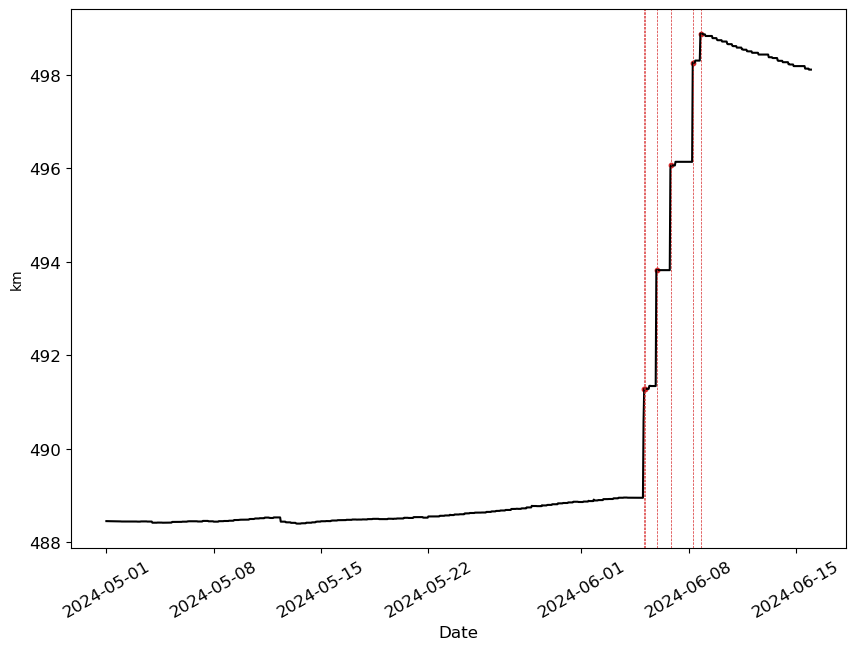

In [117]:
back=3864
plt.figure(figsize=(10, 7))
plt.xlabel("Date", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=30, fontsize=12)
plt.plot(hour_df[name].loc['2024-05-01':'2024-06-15'], color='black')

for point in [ol-back for ol in ol_lst if ol>back]:
    plt.axvline(hour_df.loc['2024-05-01':'2024-06-15'].index[point], color='tab:red', linewidth=0.5, linestyle='--')
    plt.scatter(hour_df.loc['2024-05-01':'2024-06-15'].index[point], hour_df[name].loc['2024-05-01':'2024-06-15'].iloc[point], color='tab:red', s=10)

plt.xlabel('Date')
plt.ylabel('km')